In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.2326% 	8.95756% 	0.04888		0.04619		0.0		1.0	
(1024,256) 	95.4% 		0.46004% 	6.39638% 	0.82382		0.83052		0.0		0.98705	
(1024,1024) 	3.04% 		1.85077% 	2.31983% 	0.02452		0.00362		0.0		0.95211	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.92316 0.90379 0.01937 	(688427, 0.938751472320377) 0.01368 0.93875 0.92507 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.90712 0.89420 0.01292 	(4240, 0.9623085983510011) 0.24800 0.96231 0.71431 	
(2436, 1.0) 0.98931 1.00000 0.01069 	(44828, 0.8401417658060423) 0.87922 0.84014 0.03908 	(694929, 0.9799764428739693) 0.02246 0.97998 0.95752 	
(55808, 1.0) 0.99647 1.00000 0.00353 	(232148, 0.8783613613364569) 0.88275 0.87836 0.00439 	(600540, 0.5747938751472321) 0.02171 0.57479 0.55309 	
(44159, 1.0) 0.99868 1.00000 0.00132 	(106790, 0.8420843224691953) 0.89155 0.84208 0.04947 	(226406, 0.8680800942285042) 0.07576 0.86808 0.79232 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.84106 0.82200 0.01907 	(122896, 0.99528857

(6926, 1.0) 0.98069 1.00000 0.01931 	(41727, 0.8431126758477174) 0.81029 0.84311 0.03282 	(311445, 0.9670200235571261) 0.03770 0.96702 0.92932 	
(75907, 1.0) 1.00000 1.00000 0.00000 	(128738, 0.8907939275311966) 0.85575 0.89079 0.03504 	(478600, 0.9528857479387515) 0.02298 0.95289 0.92991 	
(49659, 1.0) 1.00000 1.00000 0.00000 	(45049, 0.8941921952489368) 0.88064 0.89419 0.01356 	(1053, 0.7997644287396938) 0.26923 0.79976 0.53053 	
(1921, 1.0) 0.58188 1.00000 0.41812 	(19331, 0.7751304321123971) 0.80819 0.77513 0.03306 	(69727, 0.9187279151943463) 0.21107 0.91873 0.70766 	
(83203, 1.0) 1.00000 1.00000 0.00000 	(137038, 0.9067975246968422) 0.86215 0.90680 0.04465 	(134243, 0.9599528857479388) 0.17424 0.95995 0.78571 	
(1412, 1.0) 0.57847 1.00000 0.42153 	(230832, 0.8657114302948561) 0.88422 0.86571 0.01851 	(168119, 0.4369846878680802) 0.09498 0.43698 0.34200 	
(69505, 1.0) 0.96680 1.00000 0.03320 	(131760, 0.8853994675194621) 0.86578 0.88540 0.01962 	(26889, 0.833922261484099) 0.09504 

(23691, 1.0) 0.99228 1.00000 0.00772 	(179729, 0.8400293444585746) 0.86918 0.84003 0.02916 	(406722, 0.9505300353356891) 0.03661 0.95053 0.91392 	
(6916, 1.0) 0.89509 1.00000 0.10491 	(75799, 0.8890604238321651) 0.85698 0.88906 0.03208 	(543746, 0.9976442873969376) 0.21473 0.99764 0.78292 	
(24845, 1.0) 0.97916 1.00000 0.02084 	(247431, 0.8492179722487541) 0.88501 0.84922 0.03579 	(492664, 1.0) 0.06269 1.00000 0.93731 	
(21376, 1.0) 1.00000 1.00000 0.00000 	(170669, 0.8415475770769518) 0.89222 0.84155 0.05067 	(437407, 0.014134275618374636) 0.08204 0.01413 0.06790 	
(10422, 1.0) 0.99636 1.00000 0.00364 	(200654, 0.8441286482530976) 0.87306 0.84413 0.02893 	(15552, 0.6595995288574794) 0.31250 0.65960 0.34710 	
(10025, 1.0) 0.99983 1.00000 0.00017 	(234027, 0.8607959383741) 0.88138 0.86080 0.02058 	(53249, 0.9882214369846879) 0.31134 0.98822 0.67688 	
(34299, 1.0) 1.00000 1.00000 0.00000 	(143533, 0.8744525904866949) 0.87653 0.87445 0.00208 	(250886, 0.9623085983510011) 0.16900 0.96231 0

(49148, 1.0) 1.00000 1.00000 0.00000 	(20896, 0.8439391871763506) 0.83614 0.84394 0.00780 	(68623, 0.9976442873969376) 0.30387 0.99764 0.69377 	
(57861, 1.0) 0.99984 1.00000 0.00016 	(74555, 0.883654898393412) 0.87147 0.88365 0.01219 	(139664, 0.9646643109540636) 0.13165 0.96466 0.83302 	
(3502, 1.0) 0.16032 1.00000 0.83968 	(156980, 0.8936072949546993) 0.85886 0.89361 0.03475 	(3165, 0.96113074204947) 0.35343 0.96113 0.60770 	
(13518, 1.0) 0.99956 1.00000 0.00044 	(168684, 0.8775557081359189) 0.88659 0.87756 0.00904 	(144419, 0.9199057714958776) 0.20329 0.91991 0.71661 	
(67505, 1.0) 0.99915 1.00000 0.00085 	(88341, 0.9392154612222969) 0.90846 0.93922 0.03076 	(36871, 0.8315665488810364) 0.28739 0.83157 0.54418 	
(12037, 1.0) 0.97393 1.00000 0.02607 	(225500, 0.8809632279420466) 0.88940 0.88096 0.00843 	(213086, 0.35100117785630164) 0.10225 0.35100 0.24875 	
(61960, 1.0) 0.99474 1.00000 0.00526 	(83005, 0.8576520925643549) 0.88040 0.85765 0.02275 	(514545, 0.6466431095406361) 0.04477 

(44416, 1.0) 1.00000 1.00000 0.00000 	(112735, 0.9277083712397243) 0.94244 0.92771 0.01473 	(101381, 0.9187279151943463) 0.27737 0.91873 0.64135 	
(43219, 1.0) 0.99990 1.00000 0.00010 	(163192, 0.8520190209890851) 0.87707 0.85202 0.02505 	(311836, 0.9988221436984688) 0.03284 0.99882 0.96598 	
(17665, 1.0) 1.00000 1.00000 0.00000 	(148506, 0.9272887647592225) 0.93135 0.92729 0.00406 	(520030, 0.8939929328621907) 0.00126 0.89399 0.89273 	
(2855, 1.0) 0.17626 1.00000 0.82374 	(174392, 0.8645517849525177) 0.86399 0.86455 0.00056 	(393754, 0.7432273262661956) 0.06983 0.74323 0.67340 	
(20480, 1.0) 1.00000 1.00000 0.00000 	(219380, 0.8955193278288718) 0.90269 0.89552 0.00717 	(43, 0.03769140164899892) 0.20493 0.03769 0.16724 	
(7432, 1.0) 0.99999 1.00000 0.00001 	(177166, 0.9082845786728684) 0.86520 0.90828 0.04309 	(177205, 0.5123674911660778) 0.13457 0.51237 0.37780 	
(2175, 1.0) 0.87424 1.00000 0.12576 	(219586, 0.9018428191451707) 0.90812 0.90184 0.00628 	(636031, 0.9493521790341579) 0.0

(84480, 1.0) 1.00000 1.00000 0.00000 	(247230, 0.8442600768531928) 0.88730 0.84426 0.04304 	(899882, 0.040047114252061256) 0.00012 0.04005 0.03993 	
(2442, 1.0) 0.47947 1.00000 0.52053 	(178764, 0.8500357172026176) 0.85646 0.85004 0.00643 	(439319, 0.8916372202591284) 0.07588 0.89164 0.81576 	
(18436, 1.0) 0.96900 1.00000 0.03100 	(119362, 0.8563054776164633) 0.87914 0.85631 0.02283 	(274989, 0.7868080094228505) 0.02451 0.78681 0.76230 	
(13183, 1.0) 1.00000 1.00000 0.00000 	(207695, 0.8802417876885965) 0.88061 0.88024 0.00036 	(459029, 0.9599528857479388) 0.06875 0.95995 0.89121 	
(15629, 1.0) 0.99917 1.00000 0.00083 	(153026, 0.8394303440946921) 0.86083 0.83943 0.02140 	(279689, 0.956419316843345) 0.09832 0.95642 0.85810 	
(49561, 1.0) 1.00000 1.00000 0.00000 	(69605, 0.8154315860265511) 0.89097 0.81543 0.07554 	(730121, 1.0) 0.10657 1.00000 0.89343 	
(2322, 1.0) 0.74496 1.00000 0.25504 	(81546, 0.9404992701680478) 0.94804 0.94050 0.00754 	(62503, 0.7267373380447586) 0.21107 0.72674 

(32253, 1.0) 1.00000 1.00000 0.00000 	(71295, 0.832156820606386) 0.92525 0.83216 0.09309 	(108, 0.46760895170789174) 0.20493 0.46761 0.26268 	
(403, 1.0) 0.08231 1.00000 0.91769 	(75711, 0.829135754445261) 0.86156 0.82914 0.03242 	(43061, 0.7997644287396938) 0.21107 0.79976 0.58869 	
(44548, 1.0) 1.00000 1.00000 0.00000 	(210670, 0.8855717672116991) 0.89794 0.88557 0.01236 	(731393, 0.06242638398115429) 0.02109 0.06243 0.04133 	
(13819, 1.0) 1.00000 1.00000 0.00000 	(77619, 0.8696360964810543) 0.89642 0.86964 0.02678 	(93191, 0.96113074204947) 0.28739 0.96113 0.67374 	
(45333, 1.0) 1.00000 1.00000 0.00000 	(164382, 0.8224521256224923) 0.88001 0.82245 0.05756 	(320624, 0.9705535924617197) 0.05718 0.97055 0.91338 	
(29833, 1.0) 1.00000 1.00000 0.00000 	(184065, 0.8387689991771448) 0.87588 0.83877 0.03711 	(188764, 0.9988221436984688) 0.14039 0.99882 0.85843 	
(18304, 1.0) 1.00000 1.00000 0.00000 	(113782, 0.9629906982692393) 0.97870 0.96299 0.01571 	(68662, 1.0) 0.21107 1.00000 0.78893 	

(20255, 1.0) 0.99942 1.00000 0.00058 	(250233, 0.9003757619497575) 0.89941 0.90038 0.00096 	(205973, 0.004711425206124825) 0.04911 0.00471 0.04440 	
(10109, 1.0) 1.00000 1.00000 0.00000 	(15573, 0.7999235713645879) 0.80718 0.79992 0.00726 	(247410, 0.20023557126030625) 0.02170 0.20024 0.17853 	
(108416, 1.0) 1.00000 1.00000 0.00000 	(75173, 0.8174853669777551) 0.87012 0.81749 0.05263 	(369990, 0.9976442873969376) 0.03742 0.99764 0.96023 	
(24843, 1.0) 0.97293 1.00000 0.02707 	(90835, 0.8359099894725593) 0.88601 0.83591 0.05010 	(77854, 0.9988221436984688) 0.21710 0.99882 0.78172 	
(79235, 1.0) 1.00000 1.00000 0.00000 	(50039, 0.7863033520151788) 0.86335 0.78630 0.07705 	(146442, 0.7597173144876326) 0.29895 0.75972 0.46076 	
(20113, 1.0) 0.99997 1.00000 0.00003 	(105923, 0.8117617364765212) 0.88265 0.81176 0.07088 	(25613, 0.9328621908127209) 0.33995 0.93286 0.59291 	
(1788, 1.0) 0.62124 1.00000 0.37876 	(92278, 0.8541189502133024) 0.87937 0.85412 0.02525 	(190742, 0.9670200235571261) 0

(77060, 1.0) 1.00000 1.00000 0.00000 	(26141, 0.7679243362332615) 0.77131 0.76792 0.00339 	(616142, 0.585394581861013) 0.00758 0.58539 0.57782 	
(13956, 1.0) 0.99984 1.00000 0.00016 	(228480, 0.8894898225344138) 0.88223 0.88949 0.00726 	(128246, 0.30388692579505305) 0.13814 0.30389 0.16574 	
(18688, 1.0) 1.00000 1.00000 0.00000 	(109440, 0.903100439181739) 0.92485 0.90310 0.02175 	(209996, 0.7538280329799765) 0.12343 0.75383 0.63040 	
(43909, 1.0) 0.98712 1.00000 0.01288 	(113210, 0.9572068406600707) 0.97195 0.95721 0.01475 	(34012, 0.9587750294464076) 0.13477 0.95878 0.82401 	
(12164, 1.0) 1.00000 1.00000 0.00000 	(181477, 0.8582698587247596) 0.87653 0.85827 0.01826 	(462276, 0.8186101295641932) 0.09015 0.81861 0.72846 	
(66576, 1.0) 0.99993 1.00000 0.00007 	(31767, 0.8012019621432349) 0.82515 0.80120 0.02395 	(507024, 0.9493521790341579) 0.60740 0.94935 0.34195 	
(39037, 1.0) 1.00000 1.00000 0.00000 	(59716, 0.91944520897529) 0.89191 0.91945 0.02753 	(158779, 0.877502944640754) 0.151

(74242, 1.0) 1.00000 1.00000 0.00000 	(13885, 0.7940061024166285) 0.69117 0.79401 0.10284 	(233562, 1.0) 0.09218 1.00000 0.90782 	
(17154, 1.0) 1.00000 1.00000 0.00000 	(19069, 0.8577007729418251) 0.88207 0.85770 0.02437 	(476582, 0.9681978798586572) 0.03666 0.96820 0.93154 	
(62080, 1.0) 0.99997 1.00000 0.00003 	(53687, 0.8709568171168318) 0.88281 0.87096 0.01185 	(109699, 0.9634864546525324) 0.13958 0.96349 0.82390 	
(7931, 1.0) 0.99877 1.00000 0.00123 	(29200, 0.7458546516794506) 0.83971 0.74585 0.09386 	(76939, 0.9316843345111897) 0.15456 0.93168 0.77713 	
(79490, 1.0) 1.00000 1.00000 0.00000 	(50662, 0.8554249535178949) 0.86543 0.85542 0.01000 	(782427, 0.729093050647821) 0.00665 0.72909 0.72244 	
(52093, 1.0) 1.00000 1.00000 0.00000 	(40665, 0.8303064874773928) 0.85717 0.83031 0.02687 	(40551, 0.994110718492344) 0.25819 0.99411 0.73592 	
(41605, 1.0) 1.00000 1.00000 0.00000 	(15991, 0.7502294134136096) 0.69070 0.75023 0.05952 	(364782, 0.9340400471142521) 0.06731 0.93404 0.86673 

(9356, 1.0) 0.97182 1.00000 0.02818 	(231118, 0.8714965787999633) 0.88398 0.87150 0.01248 	(25708, 0.36395759717314485) 0.18460 0.36396 0.17935 	
(28288, 1.0) 1.00000 1.00000 0.00000 	(212061, 0.9083853608884882) 0.90905 0.90839 0.00066 	(133893, 0.9493521790341579) 0.00290 0.94935 0.94645 	
(17925, 1.0) 0.99451 1.00000 0.00549 	(101378, 0.8125518593553833) 0.85155 0.81255 0.03899 	(260269, 0.9316843345111897) 0.07585 0.93168 0.85583 	
(1917, 1.0) 0.84937 1.00000 0.15063 	(220359, 0.9025000106659193) 0.90339 0.90250 0.00089 	(272907, 0.8610129564193169) 0.06793 0.86101 0.79308 	
(1695, 1.0) 0.06819 1.00000 0.93181 	(134308, 0.8816715621973813) 0.90606 0.88167 0.02439 	(256386, 0.7938751472320377) 0.07898 0.79388 0.71490 	
(2711, 1.0) 0.78284 1.00000 0.21716 	(180785, 0.9026056911826157) 0.87784 0.90261 0.02477 	(267424, 0.502944640753828) 0.05957 0.50294 0.44338 	
(59270, 1.0) 0.99783 1.00000 0.00217 	(127751, 0.8754034413411999) 0.85985 0.87540 0.01555 	(530726, 0.92226148409894) 0.05

(43151, 1.0) 0.99833 1.00000 0.00167 	(146632, 0.9203756193125986) 0.91976 0.92038 0.00062 	(186869, 0.9905771495877504) 0.04683 0.99058 0.94375 	
(88195, 1.0) 1.00000 1.00000 0.00000 	(43129, 0.9837717148575006) 0.90960 0.98377 0.07417 	(75790, 0.9163722025912839) 0.30581 0.91637 0.61056 	
(49804, 1.0) 1.00000 1.00000 0.00000 	(59846, 0.8932541945094203) 0.86371 0.89325 0.02954 	(276594, 0.9988221436984688) 0.04139 0.99882 0.95743 	
(902, 1.0) 0.45349 1.00000 0.54651 	(62279, 0.8920165669881959) 0.87602 0.89202 0.01600 	(756784, 0.9116607773851589) 0.12559 0.91166 0.78607 	
(20223, 1.0) 1.00000 1.00000 0.00000 	(236731, 0.8878816014479707) 0.88396 0.88788 0.00392 	(34150, 0.9846878680800943) 0.09086 0.98469 0.89382 	
(34176, 1.0) 1.00000 1.00000 0.00000 	(91244, 0.9140222262110126) 0.89194 0.91402 0.02209 	(644273, 0.8798586572438163) 0.02535 0.87986 0.85451 	
(71940, 1.0) 0.99992 1.00000 0.00008 	(212404, 0.9115221924612448) 0.90973 0.91152 0.00179 	(126033, 0.9988221436984688) 0.211

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


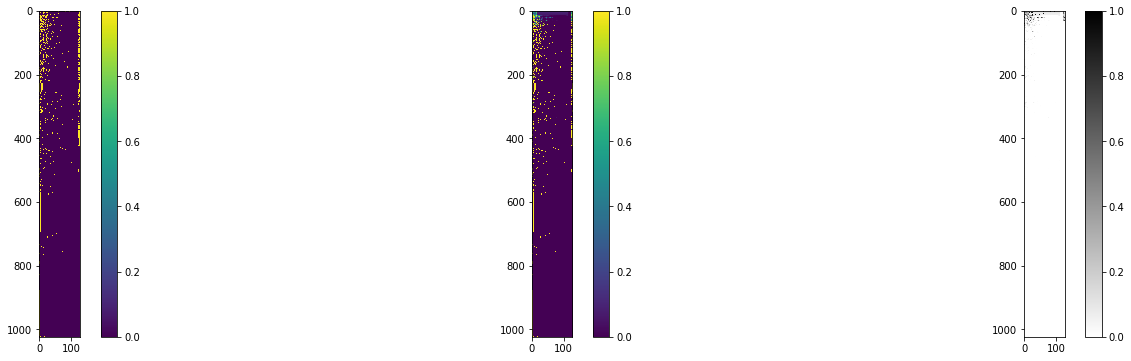

1.5581634e-08
0.987053


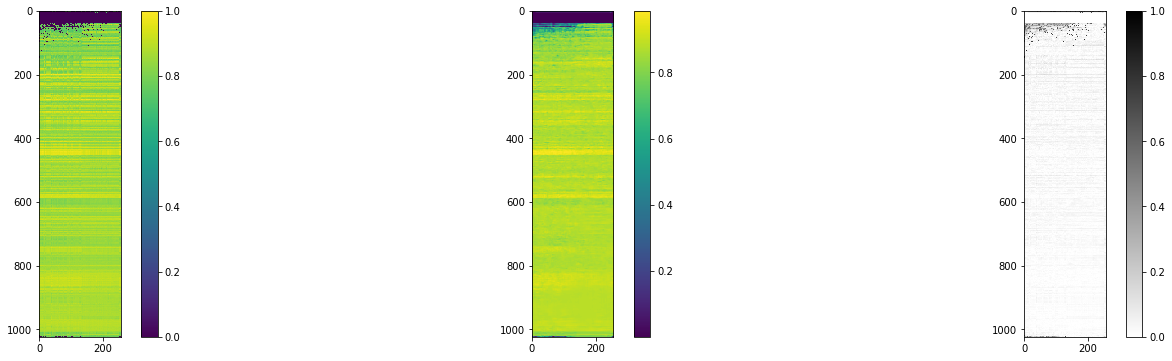

8.839596e-15
0.9521114


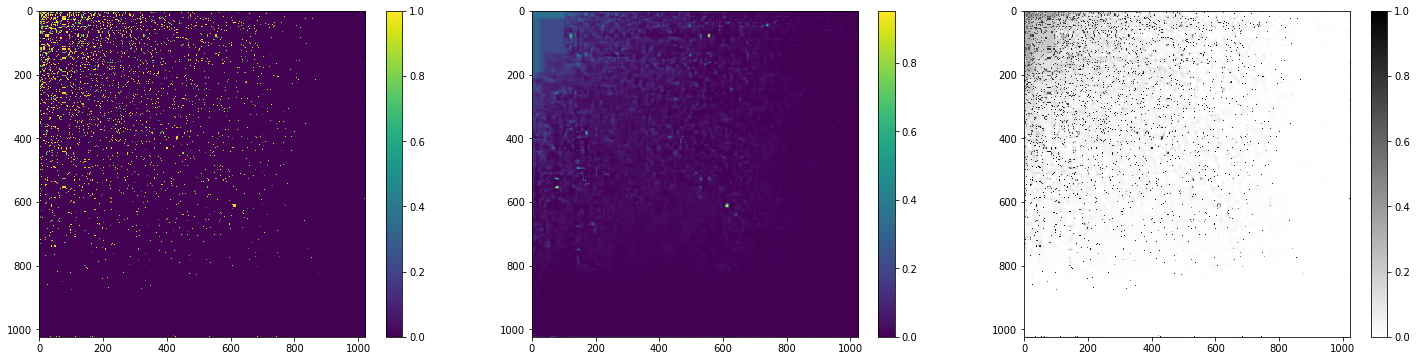

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_10/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


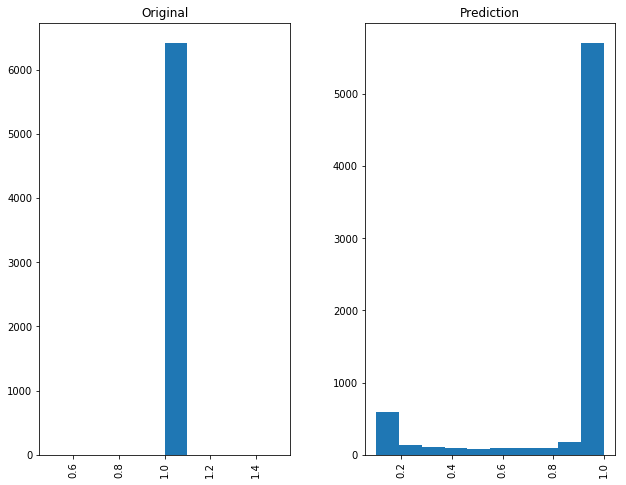

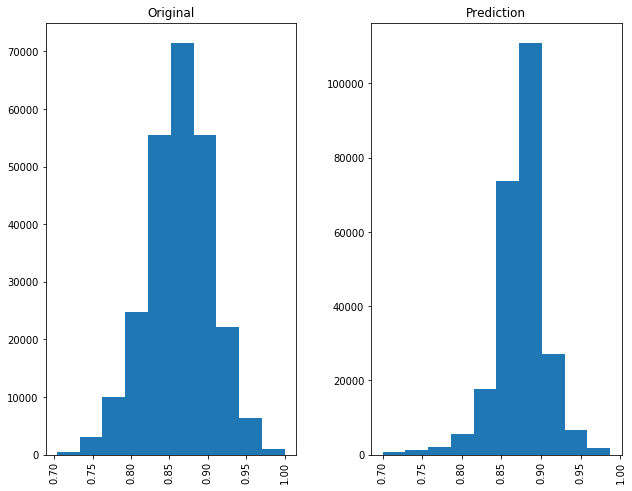

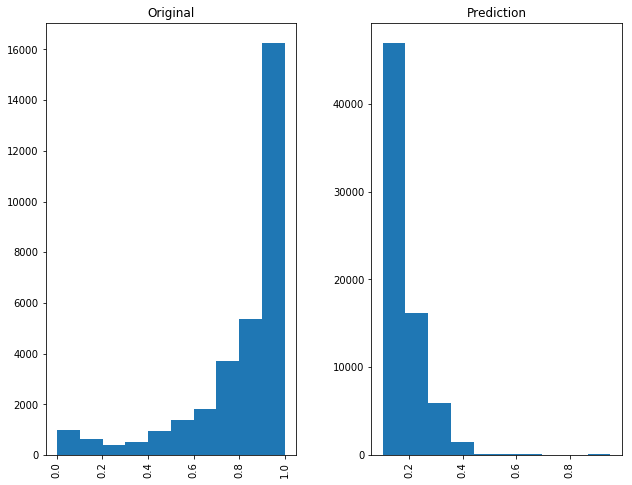

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


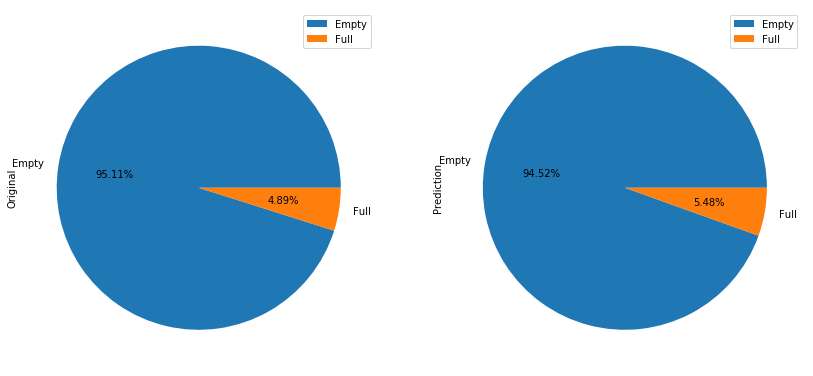

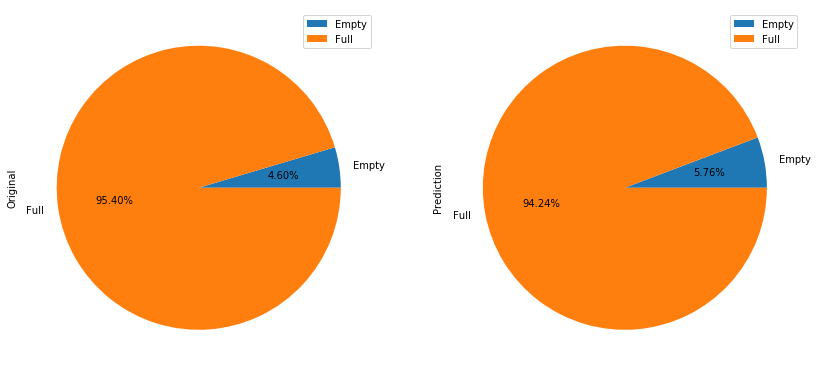

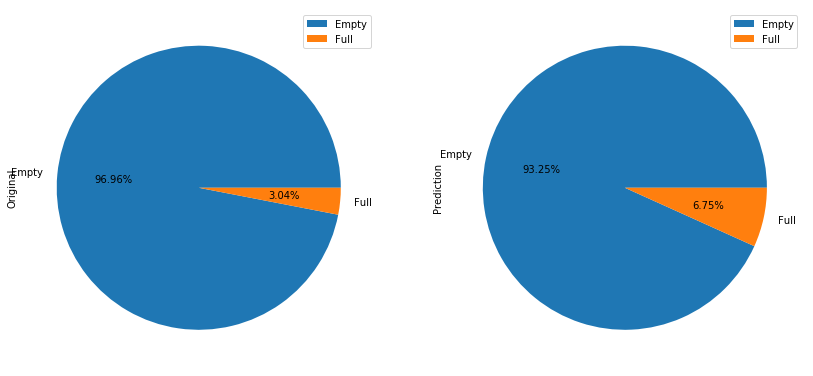

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

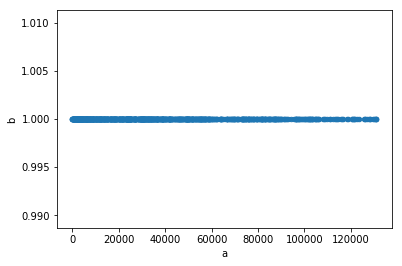

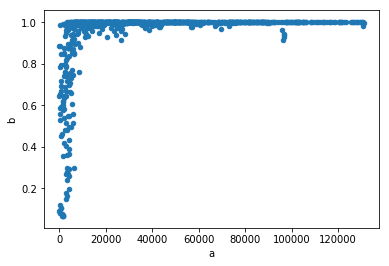

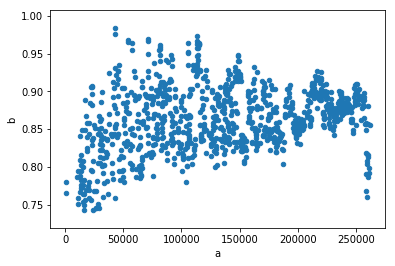

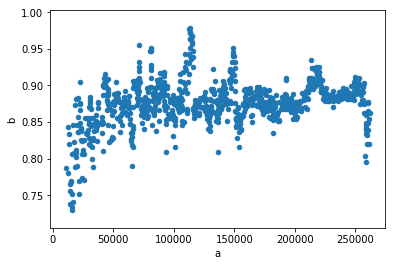

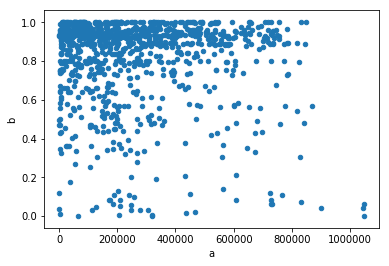

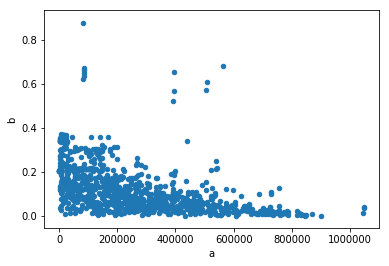

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

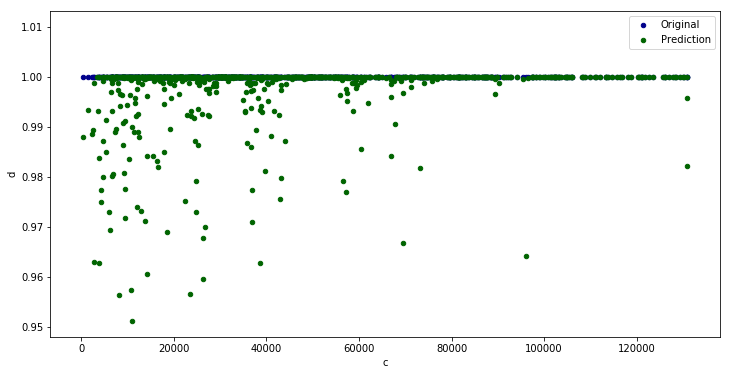

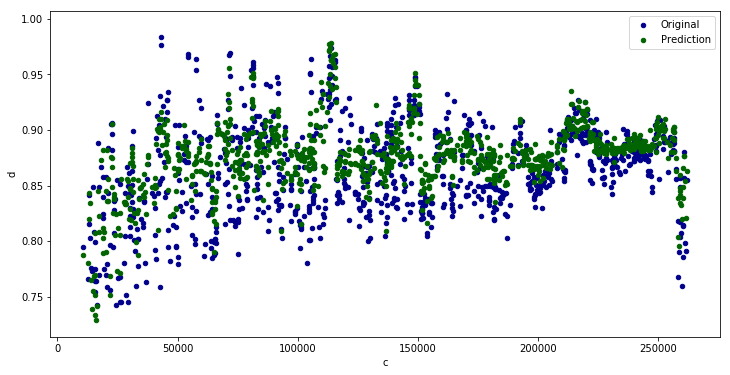

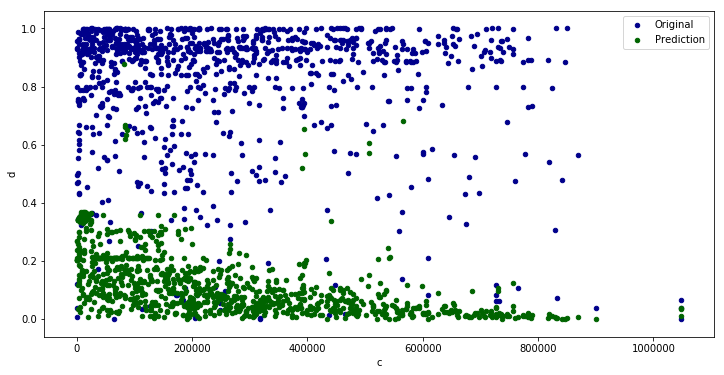

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

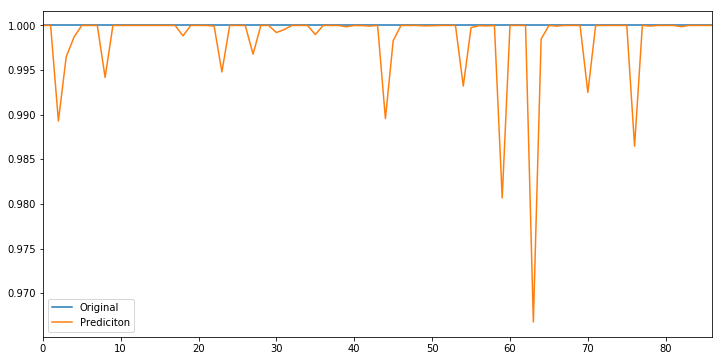

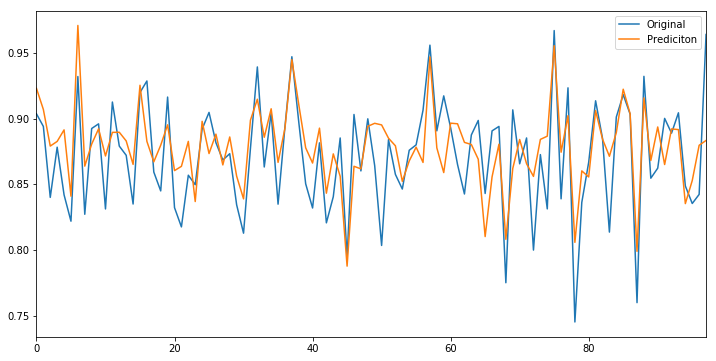

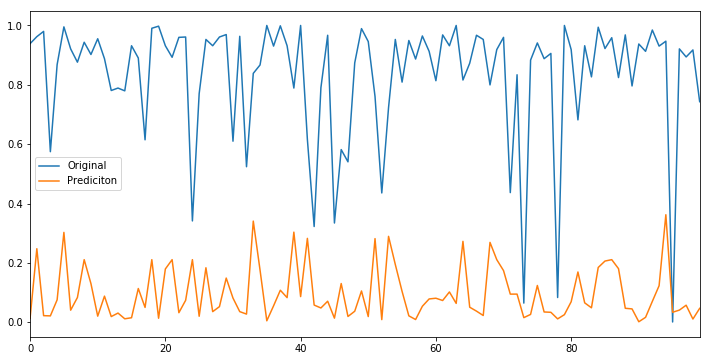

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))